In [ ]:
import pandas as pd

df = pd.read_csv('streaming_data.csv')
df.head()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49.0,Male,4700.0,3.0,Basic,NaN,3,NaN,0.0,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69.0,Female,6107.0,2.0,Standard,NaN,1,2.14,0.0,fe14b048-770b-4619-8ec6-485b0969ae31
2,44.0,Male,6374.0,3.0,Premium,1.0,1,1.91,1.0,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26.0,Male,NaN,5.0,Basic,NaN,2,NaN,NaN,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
4,18.0,NaN,1948.0,3.0,Basic,NaN,3,3.88,0.0,14879bcb-1977-4ad8-a7f9-6aa9bf7b872f


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77884 entries, 0 to 77883
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     66607 non-null  float64
 1   Gender                  63368 non-null  object 
 2   Time_on_platform        56464 non-null  float64
 3   Devices_connected       52696 non-null  float64
 4   Subscription_type       52663 non-null  object 
 5   Num_streaming_services  9572 non-null   float64
 6   Num_active_profiles     77884 non-null  int64  
 7   Avg_rating              60614 non-null  float64
 8   Churned                 61148 non-null  float64
 9   User_id                 77884 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 5.9+ MB


In [ ]:
df.describe()

,Age,Time_on_platform,Devices_connected,Num_streaming_services,Num_active_profiles,Avg_rating,Churned
count,66607.000000,56464.000000,52696.000000,9572.000000,77884.000000,60614.000000,61148.000000
mean,43.511072,4385.848505,2.995370,2.496239,3.002273,3.002252,0.243066
std,15.043158,2526.580859,1.414072,1.120700,1.413235,1.154963,0.428938
min,18.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,30.000000,2196.000000,2.000000,1.000000,2.000000,1.990000,0.000000
50%,43.000000,4384.000000,3.000000,2.000000,3.000000,3.010000,0.000000
75%,57.000000,6573.000000,4.000000,4.000000,4.000000,4.000000,0.000000
max,69.000000,8759.000000,5.000000,4.000000,5.000000,5.000000,1.000000


In [ ]:
print(df.dtypes)

Age                       float64
Gender                     object
Time_on_platform          float64
Devices_connected         float64
Subscription_type          object
Num_streaming_services    float64
Num_active_profiles         int64
Avg_rating                float64
Churned                   float64
User_id                    object
dtype: object


In [ ]:
missing_values = df.isnull().sum()

print(missing_values)

Age                       11277
Gender                    14516
Time_on_platform          21420
Devices_connected         25188
Subscription_type         25221
Num_streaming_services    68312
Num_active_profiles           0
Avg_rating                17270
Churned                   16736
User_id                       0
dtype: int64


In [ ]:
cols_to_fill = [
    "Time_on_platform",
    "Num_streaming_services",
    "Churned",
    "Avg_rating",
    "Devices_connected"
]

df[cols_to_fill] = df[cols_to_fill].fillna(0)


In [ ]:
df = df.dropna(subset=["Gender", "Subscription_type", "Age"])

print(df[["Gender", "Subscription_type", "Age"]].isnull().sum())

Gender               0
Subscription_type    0
Age                  0
dtype: int64


In [ ]:
df["Churned"] = df["Churned"].replace({0: "No", 1: "Yes"})

print(df["Churned"].value_counts())

Churned
No     29459
Yes     7056
Name: count, dtype: int64


In [ ]:
convert = [
    "Age",
    "Num_streaming_services",
    "Devices_connected",
]

df[convert] = df[convert].astype(int)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
  Churned Churn_Predicted
0      No              No
1      No              No
2     Yes              No
3      No              No
5      No              No


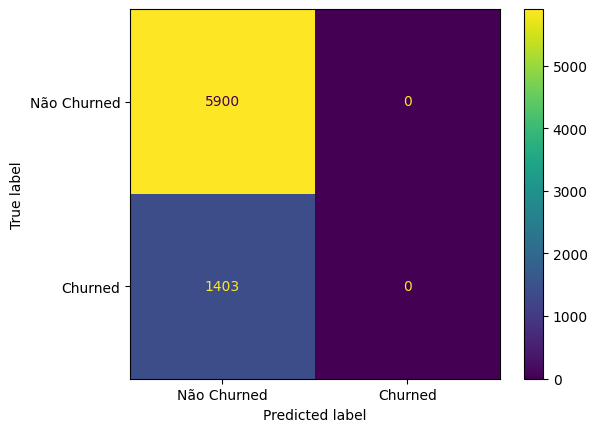

In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

label_encoder = LabelEncoder()
df['Gender_encoded'] = label_encoder.fit_transform(df['Gender'])

df = pd.get_dummies(df, columns=['Subscription_type'], drop_first=True)

X = df[['Age', 'Time_on_platform', 'Num_streaming_services', 'Avg_rating',
        'Devices_connected', 'Num_active_profiles', 'Gender_encoded'] +
        [col for col in df.columns if 'Subscription_type' in col]]

y = df['Churned']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = LogisticRegression()

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300],
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Não Churned', 'Churned'])

df_resultado = df.assign(Churn_Predicted=best_model.predict(X_scaled))

print(df_resultado[['Churned', 'Churn_Predicted']].head())

In [ ]:
print("Acurácia:", accuracy_score(y_test, y_pred))
print("Relatório de Classificação:\n", classification_report(y_test, y_pred))

Acurácia: 0.8078871696563056
Relatório de Classificação:
               precision    recall  f1-score   support

          No       0.81      1.00      0.89      5900
         Yes       0.00      0.00      0.00      1403

    accuracy                           0.81      7303
   macro avg       0.40      0.50      0.45      7303
weighted avg       0.65      0.81      0.72      7303



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fitting 3 folds for each of 6 candidates, totalling 18 fits

⏱ Tempo total: 1.24 minutos

📊 Classification Report:
              precision    recall  f1-score   support

          No       0.84      1.00      0.91      5900
         Yes       0.92      0.19      0.31      1403

    accuracy                           0.84      7303
   macro avg       0.88      0.59      0.61      7303
weighted avg       0.85      0.84      0.79      7303

Acurácia: 0.8408
  Churned Churn_Predicted
0      No              No
1      No              No
2     Yes             Yes
3      No              No
5      No              No


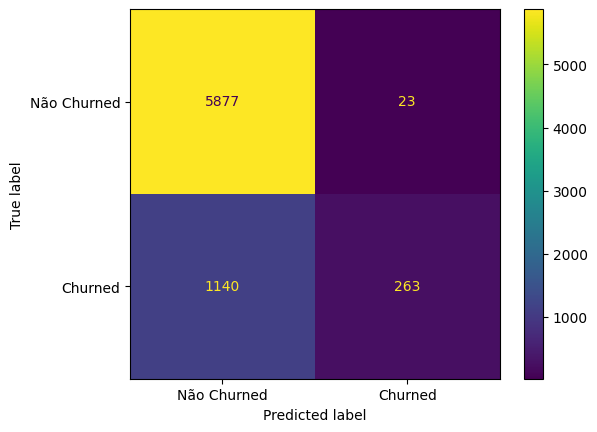

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import time

label_encoder = LabelEncoder()
df['Gender_encoded'] = label_encoder.fit_transform(df['Gender'])

X = df[['Age', 'Time_on_platform', 'Num_streaming_services', 'Avg_rating',
        'Devices_connected', 'Num_active_profiles', 'Gender_encoded'] +
       [col for col in df.columns if 'Subscription_type' in col]]

y = df['Churned']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

param_dist = {
    'n_estimators': [100, 150],
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=6,
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

start = time.time()
random_search.fit(X_train, y_train)
print(f"\n⏱ Tempo total: {(time.time() - start)/60:.2f} minutos")

best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Não Churned', 'Churned'])

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")

df_resultado = df.assign(Churn_Predicted=best_model.predict(X_scaled))
print(df_resultado[['Churned', 'Churn_Predicted']].head())

